## Setup

In [37]:
import time
import random
from math import isclose
from datetime import timedelta
from IPython.core.debugger import set_trace

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import spacy
from spacy.util import minibatch, compounding
from sklearn.metrics import confusion_matrix, classification_report

## EDA and Data Preparation

In [2]:
reviews = pd.read_csv("Yelp_restaurant_reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
review_id        100000 non-null object
stars            100000 non-null int64
text             100000 non-null object
review_length    100000 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [3]:
reviews.head()

,review_id,stars,text,review_length
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570


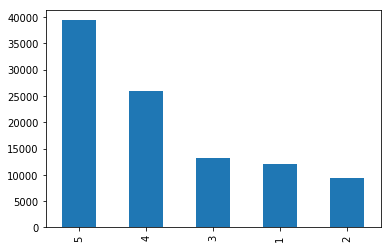

In [4]:
ax = reviews['stars'].value_counts().plot(kind='bar')  # note the bars are ordered by frequency not star number

In [5]:
# to deal with the unbalanced data (and to make the classifier binary instead of multiclass), put ratings 4-5 as positive and ratings 1-3 as negative
reviews['is_positive'] = reviews['stars'] > 3
reviews.head()

,review_id,stars,text,review_length,is_positive
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300,True
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190,True
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252,False
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326,True
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570,True


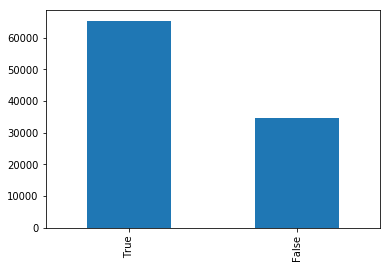

In [6]:
ax = reviews['is_positive'].value_counts().plot(kind='bar')

In [7]:
reviews['star_tuples'] = reviews.apply(lambda row: (row['text'], str(row['stars']) ), axis=1 )

In [8]:
reviews['tuples'] = reviews.apply(
    lambda row: (row['text'], row['is_positive']), axis=1)
train = reviews['tuples'].tolist()

In [9]:
train[:3]

[('The best service I had was here during my time in Las Vegas. The al a cart sides were large enough to share family style. My filet was overcooked and the server had another one out to me in minutes. The martinis were wonderful in chilled glasses with blue cheese olives. The table settings beautiful.',
  True),
 ("What a fun place. Valet parking, a great outside covered patio shared by 4 great restos! Had lunch at Bario which was good and then played some ping pong in the yard. Can't wait to go again!",
  True),
 ('My boyfriend and I dropped in for the first time on a Sunday afternoon.  The atmosphere was nice and the restaurant was very clean.  Our server Dan was knowledgeable and pleasant. The food was average but good for the price. We will definately be back.',
  False)]

In [10]:
train[-2:]

[('Super!\nMy 1st good meal in Phoenix !\nSigh ...come with family so Chinese food everyday..sucks...\n\nGood as it said ..highly recommend...\n\nThe braised short rib pizza\nPB&J smoothie',
  True),
 ('12 of us went on a Friday night. There was a large variety of food ordered and everyone enjoyed their meals. I would give 5 stars but the server was not very attentive. Wine is included. Overall an awesome value for Vegas!',
  True)]

In [9]:
reviews.head()

,review_id,stars,text,review_length,is_positive,star_tuples,tuples
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300,True,(The best service I had was here during my tim...,(The best service I had was here during my tim...
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190,True,"(What a fun place. Valet parking, a great outs...","(What a fun place. Valet parking, a great outs..."
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252,False,(My boyfriend and I dropped in for the first t...,(My boyfriend and I dropped in for the first t...
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326,True,(Excellent of breakfast or Sunday brunch! Ther...,(Excellent of breakfast or Sunday brunch! Ther...
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570,True,(I would actually give this place a 4.5 stars ...,(I would actually give this place a 4.5 stars ...


## Functions for spaCy classification

In [11]:
# get a list of labels into a format that spaCy can use
def starcats_from_labels(labels, min_stars=1, max_stars=5):
    return [
            {str(star): str(star) == y 
            for star in range(min_stars, max_stars + 1)}
            for y in labels
           ]

def poscats_from_labels(labels):
    return [{'POSITIVE': y, 'NEGATIVE': not y} for y in labels]

In [51]:
def load_data(train_list, limit=0, train_split=0.8, test_split=0, cat_function=poscats_from_labels):
    """
    Given a list of data, return training data and validation data.
    Limit is the total number of samples to use.
    train_split is what percentage to use for training. test_split is what percentage to use for testing (the rest is for validation).
    test_split is currently not used.
    
    Note: this assumes data is already shuffled (i.e., in random order)
    """
    train_data = train_list[-limit:]
    texts, labels = zip(*train_data)
    cats = cat_function(labels)
    split = int(len(train_data) * train_split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def prepare_training(train, n_texts=0, train_split=0.8, test_split=0, labels=("POSITIVE", "NEGATIVE"), 
                     cfg={"exclusive_classes": True, "architecture": "simple_cnn"}, cat_function=poscats_from_labels):
    # train_split is what percentage to use for training. test_split is what percentage to use for testing (the rest is for validation).
    # test_split is currently not used.
    if not n_texts:
        n_texts = len(train)
    nlp = spacy.load("en_core_web_sm")
    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # use config options from spacy training tutorial
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat', config=cfg)
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add labels to text classifier.
    for label in labels:
        textcat.add_label(label)

    # load the dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(train, limit=n_texts, train_split=train_split,
                                                                 test_split=test_split,
                                                                cat_function=cat_function)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))
    return train_data, nlp, (train_texts, train_cats), (dev_texts, dev_cats)

def evaluate_binary(tokenizer, textcat, texts, cats, labels=None, positive_label="POSITIVE"):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]  # gold for gold standard (the true label)
        if not labels:
            try:
                labels = sorted(set(cats.keys()))
            except AttributeError:
                labels = sorted(set(cats))
        if positive_label not in labels:
            raise ValueError("Invalid labels for binary classification")
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label != positive_label:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    # true positives + true negatives + false positives + false negatives should equal the number of documents,
    # or we've done something wrong
    assert isclose(tp + fp + tn + fn, len(texts)), (tp + fp + tn + fn, len(texts))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    cm = np.array([[tp, fn], [fp, tn]])
    metrics = {'precision': precision, 'recall': recall, 'F': f_score,
           'accuracy': accuracy, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    print(f"P: {precision:.3f}\tR: {recall:.3f}\tF: {f_score:.3f}\tA: {accuracy:.3f}")
    return metrics, cm

def evaluate_multiclass(tokenizer, textcat, texts, cats, labels=None):
    if not labels:
        try:
            labels = sorted(set(cats.keys()))
        except AttributeError:
            labels = sorted(set(cats))
    y_true = [key for entry in cats for key, value in entry.items() if value]
    y_pred = []
    docs = (tokenizer(text) for text in texts)

    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]  # gold for gold standard (the true label)
        # for multiclass, we will say that whatever the highest score is counts as the prediction.
        max_score = max(doc.cats.values())
        # checking to make sure the model isn't indecisive (i.e., assigning the same (highest) weight to multiple categories)
        if list(doc.cats.values()).count(max_score) > 1:
            raise ValueError(f'duplicate score: {max_score}')
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score == max_score:
                y_pred.append(label)

    assert len(y_true) == len(y_pred) == len(texts), (len(y_true), len(y_pred), len(texts))
    
    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    cr = classification_report(y_true, y_pred, output_dict=True)
    metrics = dict()
    for key, value in cr.items():
        if key == "accuracy":
            metrics[key] = value
        elif "avg" in key:
            key_suffix = key.replace(" ", "-")
            for metric_name, avg_score in value.items():
                if metric_name == "support":
                    # redundant information; we already know how many examples we have
                    continue
                # if the name is f1-score, change it to f1
                metric_name = metric_name.replace("f1-score", "f1")
                # example: precision_macro-avg
                metrics[f"{metric_name}_{key_suffix}"] = avg_score
        else:
            try:
                for metric_name, avg_score in value.items():
                    # if the name is f1-score, change it to f1
                    metric_name = metric_name.replace("f1-score", "f1")
                    # example: 1_recall
                    metrics[f"{key}_{metric_name}"] = avg_score
            except ValueError as e:
                print(value)
                raise e
    
    for key, value in cr.items():
        if type(value) != dict:
            metrics[key] = value
        else:
            for k, v in value.items():
                # store data in long form
                metrics[f"{key.replace(' ', '-')}"] = v
                metrics["category"] = k
    
    return metrics, cm

In [45]:
def do_training(train_data, nlp, train_info, dev_info, n_iter=10, batch_sizes=None, drop=0.2,
               evaluate=None, labels=("POSITIVE", "NEGATIVE")):
    if not batch_sizes:
        batch_sizes = compounding(4.0, 32.0, 1.001)
    if not evaluate:
        if len(labels) > 2:
            evaluate = evaluate_multiclass
        else:
            evaluate = evaluate_binary
    # get names of other pipes to disable them during training
    # the last two are for if you are using transformers (see https://spacy.io/models/en-starters)
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    train_texts, train_cats = train_info
    dev_texts, dev_cats = dev_info

    metrics = {'iteration': [], 'loss': [], 'cm_train': [], 'cm_validation': []}
    textcat = nlp.get_pipe('textcat')

    start = time.time()
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('precision (P)\trecall (R)\tF-score (F)\taccuracy (A)')
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=drop, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                print(f"iteration: {i}, loss: {losses['textcat']:.5f}")
                print("training scores, then validation scores")
                train_scores, train_cm = evaluate(nlp.tokenizer, textcat, train_texts, train_cats, labels=labels)
                dev_scores, dev_cm = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats, labels=labels)
                metrics['iteration'].append(i)
                metrics['loss'].append(losses['textcat'])
                for name, score_dict in zip(('train', 'validation'), (train_scores, dev_scores)):
                    for key, val in score_dict.items():
                        if f"{key}_{name}" not in metrics:
                            metrics[f"{key}_{name}"] = []
                        metrics[f"{key}_{name}"].append(val)
                metrics['cm_train'].append(train_cm)
                metrics['cm_validation'].append(dev_cm)

    end = time.time()
    training_time = timedelta(seconds = end - start)
    print("Training time:", training_time)
    metrics = pd.DataFrame(metrics)
    return metrics

## Binary classifier (positive or negative)

### Simple CNN (binary classifier)

In [15]:
train_data, nlp, train_info, dev_info = prepare_training(train, n_texts=25000, train_split=0.8)
metrics_bcnn = do_training(train_data, nlp, train_info, dev_info, labels=('POSITIVE', 'NEGATIVE'), n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
precision (P)	recall (R)	F-score (F)	accuracy (A)
iteration: 0, loss: 12.03091
training scores, then validation scores
P: 0.917	R: 0.941	F: 0.929	A: 0.906
P: 0.891	R: 0.912	F: 0.901	A: 0.871
iteration: 1, loss: 0.11223
training scores, then validation scores
P: 0.937	R: 0.956	F: 0.946	A: 0.929
P: 0.897	R: 0.919	F: 0.908	A: 0.879
iteration: 2, loss: 0.08243
training scores, then validation scores
P: 0.948	R: 0.970	F: 0.959	A: 0.946
P: 0.897	R: 0.924	F: 0.910	A: 0.882
iteration: 3, loss: 0.07195
training scores, then validation scores
P: 0.961	R: 0.977	F: 0.969	A: 0.959
P: 0.898	R: 0.923	F: 0.911	A: 0.882
iteration: 4, loss: 0.06176
training scores, then validation scores
P: 0.969	R: 0.983	F: 0.976	A: 0.968
P: 0.900	R: 0.918	F: 0.909	A: 0.880
iteration: 5, loss: 0.05175
training scores, then validation scores
P: 0.980	R: 0.986	F: 0.983	A: 0.978
P: 0.902	R: 0.916	F: 0.909	A: 0.881
iteration: 6, lo

In [16]:
metrics_bcnn.head()

,iteration,loss,cm_train,cm_validation,precision_train,recall_train,F_train,accuracy_train,tp_train,tn_train,fp_train,fn_train,precision_validation,recall_validation,F_validation,accuracy_validation,tp_validation,tn_validation,fp_validation,fn_validation
0,0,12.030912,"[[12302.00000001, 767.00000001], [1113.0000000...","[[2956.00000001, 285.00000001], [361.00000001,...",0.917033,0.941312,0.929014,0.90600,12302.0,5818.0,1113.0,767.0,0.891167,0.912064,0.901494,0.8708,2956.0,1398.0,361.0,285.0
1,1,0.112233,"[[12496.00000001, 573.00000001], [841.00000001...","[[2979.00000001, 262.00000001], [341.00000001,...",0.936942,0.956156,0.946452,0.92930,12496.0,6090.0,841.0,573.0,0.897289,0.919161,0.908093,0.8794,2979.0,1418.0,341.0,262.0
2,2,0.082427,"[[12680.00000001, 389.00000001], [698.00000001...","[[2995.00000001, 246.00000001], [345.00000001,...",0.947825,0.970235,0.958899,0.94565,12680.0,6233.0,698.0,389.0,0.896707,0.924098,0.910196,0.8818,2995.0,1414.0,345.0,246.0
3,3,0.071950,"[[12774.00000001, 295.00000001], [516.00000001...","[[2991.00000001, 250.00000001], [338.00000001,...",0.961174,0.977428,0.969233,0.95945,12774.0,6415.0,516.0,295.0,0.898468,0.922863,0.910502,0.8824,2991.0,1421.0,338.0,250.0
4,4,0.061763,"[[12847.00000001, 222.00000001], [408.00000001...","[[2975.00000001, 266.00000001], [332.00000001,...",0.969219,0.983013,0.976067,0.96850,12847.0,6523.0,408.0,222.0,0.899607,0.917927,0.908674,0.8804,2975.0,1427.0,332.0,266.0


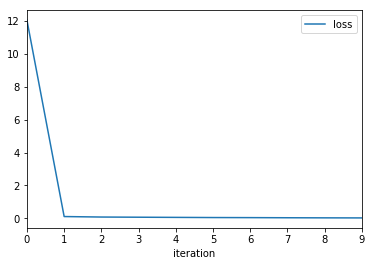

In [17]:
metrics_bcnn.plot(x='iteration', y='loss')

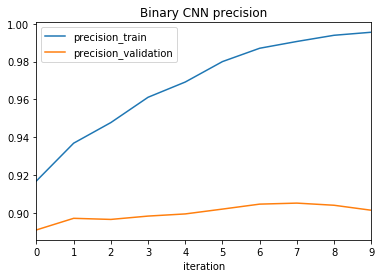

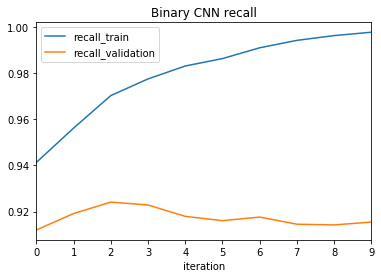

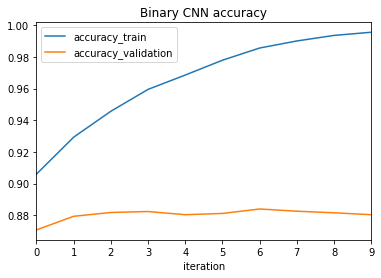

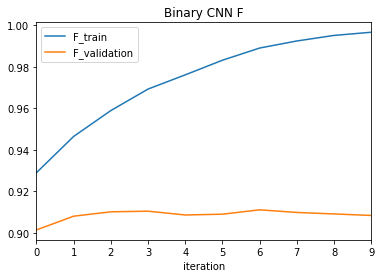

In [135]:
for metric in ["precision", "recall", "accuracy", "F"]:
    ax = metrics_bcnn.plot(x="iteration", y=f"{metric}_train")
    ax = metrics_bcnn.plot(x="iteration", y=f"{metric}_validation", ax=ax)
    ax.set_title(f'Binary CNN {metric}')

Looks quite good. Might be wise to implement early stopping since validation doesn't seem to be improving.

Note: F-score (also called F1 score) is the harmonic mean of precision and recall: 2\*(precision*recall)/(precision+recall). The best possible value is 1 (which would mean perfect precision and perfect recall). This measure assumes precision and recall are equally important, which may not be true for all problems. https://en.wikipedia.org/wiki/F1_score

In [142]:
def plot_cm(cm, percent=False, labels=('POSITIVE', 'NEGATIVE'), title="Confusion Matrix"):
    # from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    if percent:
        matrix = cm / cm.sum()
    else:
        matrix = cm
    ax = plt.subplot()
    # annot=True to annotate cells, fmt='g' so that we don't get scientific notation
    # fmt='g' from https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    sns.heatmap(matrix, annot=True, fmt='g', ax = ax); 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    return ax

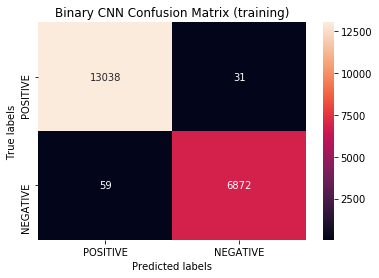

In [150]:
# iloc[-1] gets the last row (i.e., the most recent iteration)
plot_cm(metrics_bcnn['cm_train'].iloc[-1], title="Binary CNN Confusion Matrix (training)")

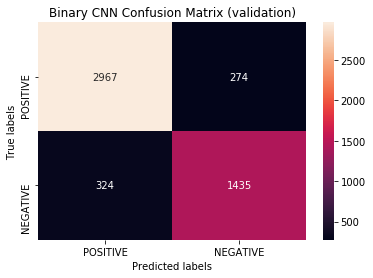

In [151]:
plot_cm(metrics_bcnn['cm_validation'].iloc[-1], title="Binary CNN Confusion Matrix (validation)")

#### Checking balance of training data
Did our validation set have a lower percentage of positive examples than our test set?

In [22]:
_, train_cats = train_info
num_n = 0
for row in train_cats:
    for key, value in row.items():
        if key == 'NEGATIVE' and value is True:
            num_n += 1
num_p = len(train_cats) - num_n
print(f"{num_p} positive examples, {num_n} negative examples, {num_p/len(train_cats)*100:.2f}% positive")

13069 positive examples, 6931 negative examples, 65.34% positive


In [23]:
_, dev_cats = dev_info
dev_n = 0
dev_p = 0
for row in dev_cats:
    for key, value in row.items():
        if key == 'NEGATIVE' and value is True:
            dev_n += 1
dev_p = len(dev_cats) - dev_n
print(f"{dev_p} positive examples, {dev_n} negative examples, {dev_p/len(dev_cats)*100:.2f}% positive")

3241 positive examples, 1759 negative examples, 64.82% positive


Yes, there was a slightly lower percentage of positive examples in the validation set.

### Bag of words (binary classifier)

In [24]:
train_data, nlp, train_info, dev_info = prepare_training(train, n_texts=25000, train_split=0.8, cfg={"exclusive_classes": True, "architecture": "bow"})
metrics_bbow = do_training(train_data, nlp, train_info, dev_info, labels=('POSITIVE', 'NEGATIVE'), n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
precision (P)	recall (R)	F-score (F)	accuracy (A)
iteration: 0, loss: 11.16402
training scores, then validation scores
P: 0.914	R: 0.950	F: 0.932	A: 0.909
P: 0.882	R: 0.920	F: 0.901	A: 0.869
iteration: 1, loss: 0.12190
training scores, then validation scores
P: 0.932	R: 0.961	F: 0.946	A: 0.928
P: 0.888	R: 0.919	F: 0.903	A: 0.872
iteration: 2, loss: 0.08595
training scores, then validation scores
P: 0.944	R: 0.966	F: 0.955	A: 0.941
P: 0.888	R: 0.919	F: 0.903	A: 0.872
iteration: 3, loss: 0.07735
training scores, then validation scores
P: 0.952	R: 0.972	F: 0.961	A: 0.949
P: 0.887	R: 0.918	F: 0.902	A: 0.871
iteration: 4, loss: 0.07062
training scores, then validation scores
P: 0.957	R: 0.975	F: 0.966	A: 0.955
P: 0.890	R: 0.915	F: 0.902	A: 0.872
iteration: 5, loss: 0.06776
training scores, then validation scores
P: 0.961	R: 0.978	F: 0.969	A: 0.960
P: 0.889	R: 0.914	F: 0.901	A: 0.870
iteration: 6, lo

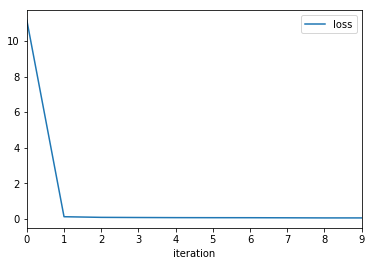

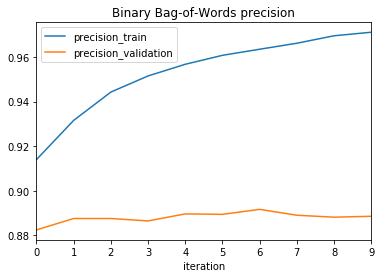

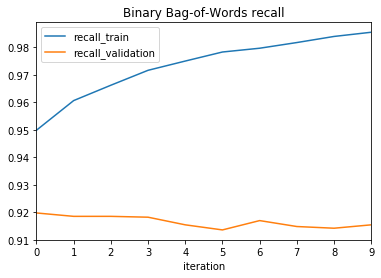

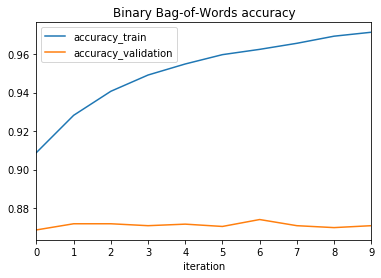

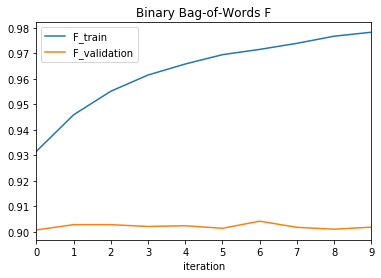

In [146]:
metrics_bbow.plot(x='iteration', y='loss')
for metric in ["precision", "recall", "accuracy", "F"]:
    ax = metrics_bbow.plot(x="iteration", y=f"{metric}_train")
    ax = metrics_bbow.plot(x="iteration", y=f"{metric}_validation", ax=ax)
    ax.set_title(f'Binary Bag-of-Words {metric}')

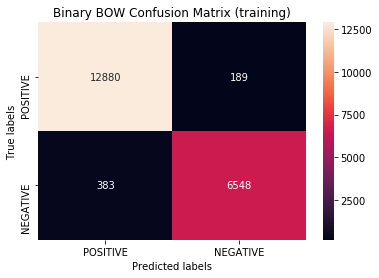

In [152]:
plot_cm(metrics_bbow['cm_train'].iloc[-1], title="Binary BOW Confusion Matrix (training)")

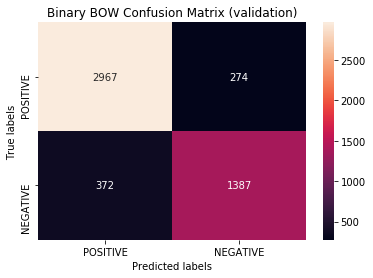

In [153]:
plot_cm(metrics_bbow['cm_validation'].iloc[-1], title="Binary BOW Confusion Matrix (validation)")

It all looks about the same as with the CNN to me.

### Comparing CNN and Bag of Words (binary classifier)

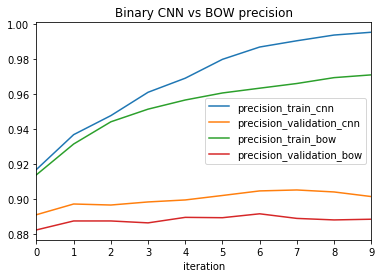

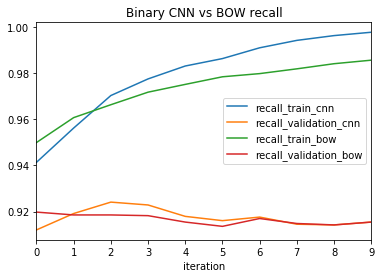

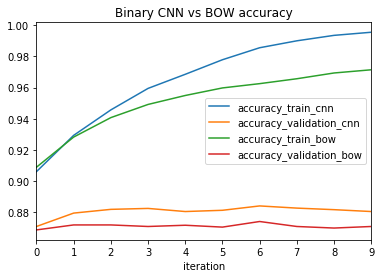

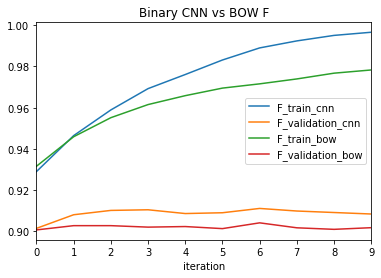

In [149]:
for metric in ["precision", "recall", "accuracy", "F"]:
    ax = metrics_bcnn.plot(x="iteration", y=f"{metric}_train", label=f"{metric}_train_cnn")
    metrics_bcnn.plot(x="iteration", y=f"{metric}_validation", label=f"{metric}_validation_cnn", ax=ax)
    metrics_bbow.plot(x="iteration", y=f"{metric}_train", label=f"{metric}_train_bow", ax=ax)
    metrics_bbow.plot(x="iteration", y=f"{metric}_validation", label=f"{metric}_validation_bow", ax=ax)
    ax.set_title(f"Binary CNN vs BOW {metric}")

Convolutional neural network does better than bag of words in all metrics (not sure that it's enough better to justify the extra complexity/runtime). The biggest difference is in precision. BOW starts out better than CNN in recall, but CNN quickly surpasses BOW.

## Multiclass classification (star rating)

### Bag of words (multiclass classifier)

In [28]:
train_star = reviews['star_tuples'].tolist()

In [52]:
star_labels = [str(star) for star in range(1,6)]
train_data, nlp, train_info, dev_info = prepare_training(train_star, n_texts=25000, train_split=0.8, cfg={"exclusive_classes": True, "architecture": "bow"},
                                                        labels=star_labels, cat_function=starcats_from_labels)
metrics_mbow = do_training(train_data, nlp, train_info, dev_info, labels=star_labels, n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
precision (P)	recall (R)	F-score (F)	accuracy (A)
iteration: 0, loss: 23.97857
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.77      0.80      0.79      2462
           2       0.67      0.45      0.54      1864
           3       0.63      0.52      0.57      2605
           4       0.64      0.60      0.62      5225
           5       0.75      0.87      0.81      7844

    accuracy                           0.71     20000
   macro avg       0.69      0.65      0.66     20000
weighted avg       0.70      0.71      0.70     20000

              precision    recall  f1-score   support

           1       0.61      0.74      0.67       559
           2       0.38      0.20      0.27       513
           3       0.41      0.31      0.35       687
           4       0.48      0.48      0.48      1280
           5       0.69     

iteration: 8, loss: 0.16762
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.94      0.95      0.94      2462
           2       0.92      0.87      0.89      1864
           3       0.90      0.83      0.86      2605
           4       0.87      0.82      0.84      5225
           5       0.88      0.94      0.91      7844

    accuracy                           0.89     20000
   macro avg       0.90      0.88      0.89     20000
weighted avg       0.89      0.89      0.89     20000

              precision    recall  f1-score   support

           1       0.64      0.74      0.69       559
           2       0.43      0.30      0.35       513
           3       0.43      0.36      0.39       687
           4       0.47      0.47      0.47      1280
           5       0.71      0.77      0.74      1961

    accuracy                           0.59      5000
   macro avg       0.54      0.53      0.53      5000
weighted 

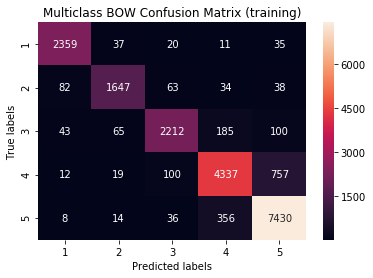

In [155]:
plot_cm(metrics_mbow['cm_train'].iloc[-1], title="Multiclass BOW Confusion Matrix (training)", labels=star_labels, percent=False)

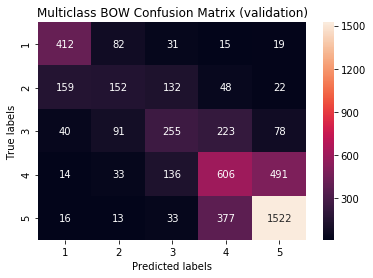

In [156]:
plot_cm(metrics_mbow['cm_validation'].iloc[-1], title="Multiclass BOW Confusion Matrix (validation)", labels=star_labels, percent=False)

For labels that are misclassified, the incorrect label is usually close to the correct one (misclassifying a 4 as a 5, for example). That's good. I do wonder about why in the validation set 2s are classified as 1s much more often than 1s are classified as 2s. Did our validation set have a different proportion of 2s than our test set? If we had more 2s in the validation set, that would explain this pattern.

In [32]:
star_labels

['1', '2', '3', '4', '5']

In [33]:
_, train_cats = train_info
train_cat_counts = {label: 0 for label in star_labels}
for row in train_cats:
    for key, value in row.items():
        if value is True:
            train_cat_counts[key] += 1
print(train_cat_counts)

{'1': 2462, '2': 1864, '3': 2605, '4': 5225, '5': 7844}


In [34]:
_, dev_cats = dev_info
dev_cat_counts = {label: 0 for label in star_labels}
for row in dev_cats:
    for key, value in row.items():
        if value is True:
            dev_cat_counts[key] += 1
dev_cat_counts

{'1': 559, '2': 513, '3': 687, '4': 1280, '5': 1961}

In [117]:
def plot_support(metrics, traintype='train', labels=("1", "2", "3", "4", "5")):
    metrics_final = metrics.iloc[-1]
    for label in labels:
        plt.bar(x=f'{label}_{traintype}', height=metrics_final[f'{label}_support_{traintype}'])

Train and validation have about the same proportions of samples in each category, although in validation the number of examples in category 2 is closer to the number of examples in category 1. So that explains why in the validation set 2s are classified as 1s much more often than 1s are classified as 2s.

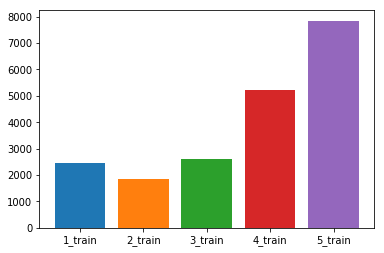

In [120]:
plot_support(metrics_mbow, traintype='train')

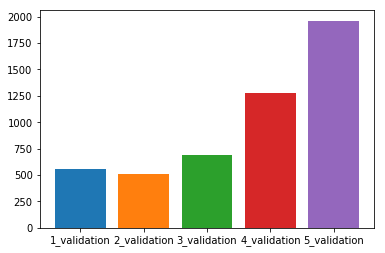

In [121]:
plot_support(metrics_mbow, traintype='validation')

In [125]:
def plot_class_basic_metrics(metrics):
    metrics.plot(x='iteration', y='loss')
    ax = metrics.plot(x="iteration", y=f"accuracy_train")
    metrics.plot(x="iteration", y=f"accuracy_validation", ax=ax)
    for metric in ["precision", "recall"]:
        ax = metrics.plot(x="iteration", y=f"{metric}_macro-avg_train")
        metrics.plot(x="iteration", y=f"{metric}_macro-avg_validation", ax=ax)
        metrics.plot(x="iteration", y=f"{metric}_weighted-avg_train", ax=ax)
        metrics.plot(x="iteration", y=f"{metric}_weighted-avg_validation", ax=ax)

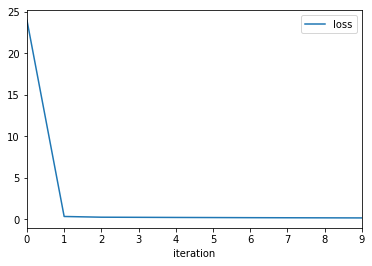

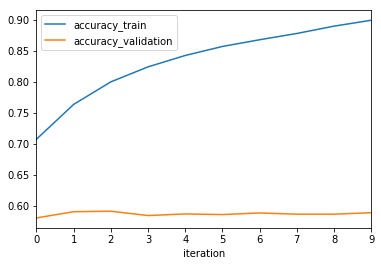

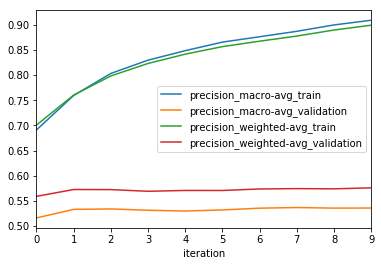

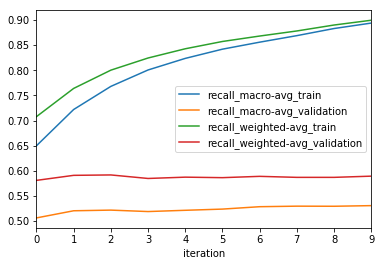

In [73]:
plot_class_basic_metrics(metrics_mbow)

In [166]:
def plot_class_label_metrics(metrics, labels=("1", "2", "3", "4", "5"), kind='line'):
    
    # TODO: spaghetti plot with bad colors. Too much to show here, or just not showing well?
    
    precision_ax = None
    recall_ax = None
    f1_ax = None
    
    if kind == 'line':
        for label in labels:
            for traintype in ["train", "validation"]:
                precision_ax = metrics.plot(x="iteration", y=f"{label}_precision_{traintype}", label=f"{label}_{traintype}", 
                                            ax=precision_ax)
                recall_ax = metrics.plot(x="iteration", y=f"{label}_recall_{traintype}", label=f"{label}_{traintype}", 
                                         ax=recall_ax)
                f1_ax = metrics.plot(x="iteration", y=f"{label}_f1_{traintype}", label=f"{label}_{traintype}",
                                     ax=f1_ax)
    elif kind == 'bar':
        final_metrics = metrics.iloc[-1]  # get the last row of the dataframe
        for label in labels:
            for traintype in ["train", "validation"]:
                precision_ax = final_metrics.plot(y=f"{label}_precision_{traintype}", ax=precision_ax, kind='bar')
                recall_ax = final_metrics.plot(y=f"{label}_recall_{traintype}", ax=recall_ax, kind='bar')
                f1_ax = final_metrics.plot(y=f"{label}_f1_{traintype}", ax=f1_ax, kind='bar')
    for ax, label in zip((precision_ax, recall_ax, f1_ax), ('precision', 'recall', 'f1')):
        ax.set_title(f"Multiclass {label}")

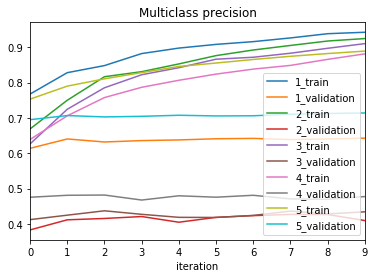

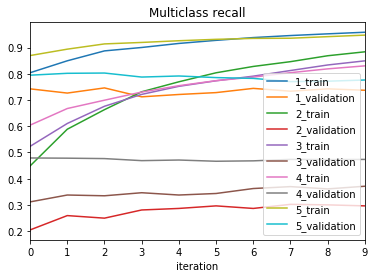

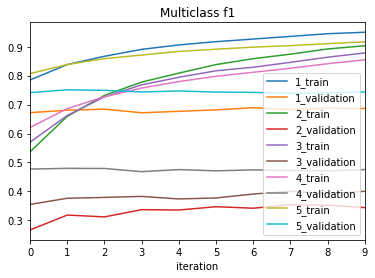

In [167]:
plot_class_label_metrics(metrics_mbow)

For the training data, with more iterations the scores improve in all categories. For the validation data, the scores are about the same throughout training.

The more extreme categories (1 and 5) do better than the less extreme categories (2-4). This pattern holds for every metric in the validation data and for recall and f1 in the training data. For the validation data, category 4 does better than categories 3 and 2. I think this is because there is more data for category 4.

For precision in the training data, category 5 is eventually surpassed by categories 2 and 3. I think this is because category 5 has the challenge that there are a lot of category 4s that are probably quite similar, and categories 2 and 3 don't have nearly as many examples to be confused by. Another factor that may cause this effect is that there are a lot of training examples in category 5 (so the model learns how to identify a 5 pretty quickly) and few examples in categories 2 and 3 (so it takes longer for the model to have seen enough 2s and 3s to be good at identifying them).

#### Try the multiclass BOW classifier on texts I made up

This uses the latest-run classifier.

In [180]:
test_text5 = "The pizza was amazing! Best food I ever had."
doc = nlp(test_text5)
doc.cats

{'1': 0.003921210300177336,
 '2': 0.0038604980800300837,
 '3': 0.003649379126727581,
 '4': 0.08383528888225555,
 '5': 0.9047336578369141}

In [181]:
test_text4 = "The pizza was pretty good. I wish it had had more cheese though. Servers were friendly."
doc = nlp(test_text4)
doc.cats

{'1': 0.01670799031853676,
 '2': 0.06390266865491867,
 '3': 0.2670528292655945,
 '4': 0.5420358180999756,
 '5': 0.1103006973862648}

In [182]:
test_text3 = "The pizza was a bit expensive, especially given the slow service. It tasted delicious though."
doc = nlp(test_text3)
doc.cats

{'1': 0.029756082221865654,
 '2': 0.16440513730049133,
 '3': 0.3960275948047638,
 '4': 0.376434326171875,
 '5': 0.033376894891262054}

In [183]:
test_text2 = "It's ok, but not as good as other pizza places I've been to. My biggest complaint is how noisy the place was."
doc = nlp(test_text2)
doc.cats

{'1': 0.013877415098249912,
 '2': 0.3000626266002655,
 '3': 0.4672316610813141,
 '4': 0.1868385374546051,
 '5': 0.031989775598049164}

In [188]:
test_text22 = "The restaurant was really messy. I wouldn't come back there again."
doc = nlp(test_text22)
doc.cats

{'1': 0.2255639135837555,
 '2': 0.10057520121335983,
 '3': 0.241531103849411,
 '4': 0.30131763219833374,
 '5': 0.1310121715068817}

In [189]:
test_text22 = "The restaurant was messy. I wouldn't come back there again."
doc = nlp(test_text22)
doc.cats

{'1': 0.3077126145362854,
 '2': 0.11253245174884796,
 '3': 0.22275550663471222,
 '4': 0.24006731808185577,
 '5': 0.11693211644887924}

As you can see the classifier has some peculiarities. For example, "really" makes a document more likely to fit into a higher category, even though really can modify a negative adjective). This would be less of an issue with a larger ngram size since then the model could distinguish between "really good" and "really bad".

### Simple CNN (multiclass classifier)

Note: I discovered a typo where I ran `"bow"` instead of multiclass here.

In [190]:
train_data, nlp, train_info, dev_info = prepare_training(train_star, n_texts=25000, train_split=0.8, cfg={"exclusive_classes": True, "architecture": "cnn"},
                                                        labels=star_labels, cat_function=starcats_from_labels)
metrics_mcnn = do_training(train_data, nlp, train_info, dev_info, labels=star_labels, n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
precision (P)	recall (R)	F-score (F)	accuracy (A)
iteration: 0, loss: 24.93578
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.62      0.84      0.71      2462
           2       0.44      0.15      0.23      1864
           3       0.49      0.40      0.44      2605
           4       0.51      0.34      0.41      5225
           5       0.67      0.90      0.77      7844

    accuracy                           0.61     20000
   macro avg       0.55      0.53      0.51     20000
weighted avg       0.58      0.61      0.57     20000

              precision    recall  f1-score   support

           1       0.56      0.82      0.66       559
           2       0.44      0.14      0.21       513
           3       0.43      0.32      0.37       687
           4       0.44      0.31      0.37      1280
           5       0.66     

iteration: 8, loss: 0.20619
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.86      0.94      0.90      2462
           2       0.78      0.65      0.70      1864
           3       0.79      0.76      0.77      2605
           4       0.80      0.77      0.79      5225
           5       0.88      0.93      0.90      7844

    accuracy                           0.84     20000
   macro avg       0.82      0.81      0.81     20000
weighted avg       0.84      0.84      0.84     20000

              precision    recall  f1-score   support

           1       0.66      0.76      0.71       559
           2       0.48      0.40      0.44       513
           3       0.48      0.41      0.44       687
           4       0.50      0.51      0.50      1280
           5       0.74      0.78      0.76      1961

    accuracy                           0.62      5000
   macro avg       0.58      0.57      0.57      5000
weighted 

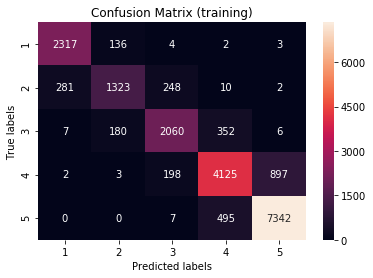

In [197]:
plot_cm(metrics_mcnn['cm_train'].iloc[-1], title="Confusion Matrix (training)", labels=star_labels, percent=False)

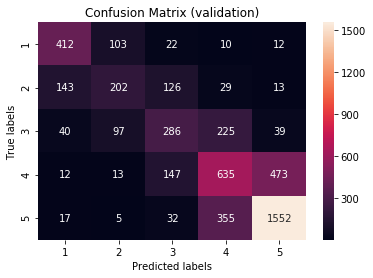

In [198]:
plot_cm(metrics_mcnn['cm_validation'].iloc[-1], title="Confusion Matrix (validation)", labels=star_labels, percent=False)

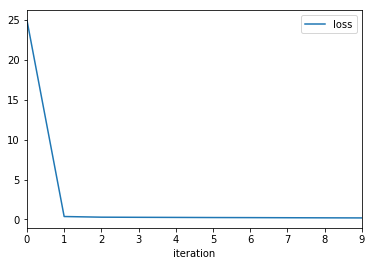

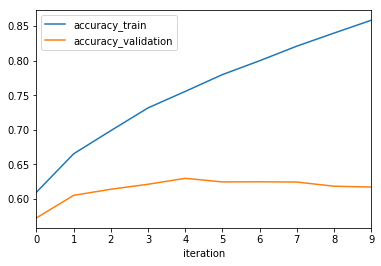

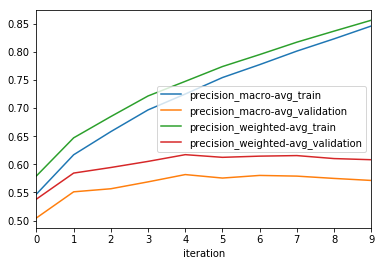

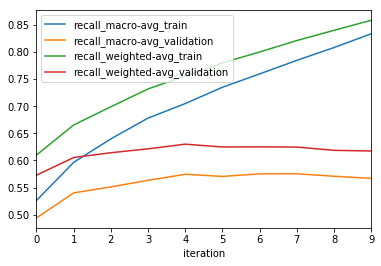

In [199]:
plot_class_basic_metrics(metrics_mcnn)

Precision, accuracy and recall get better over time in both training and validation. It looks like by iteration 4, the metrics for the validation set do not improve (but they don't get much worse).

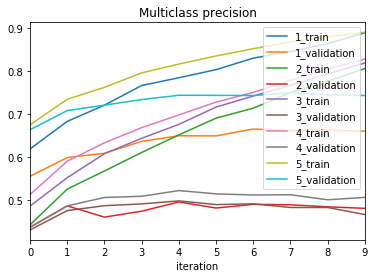

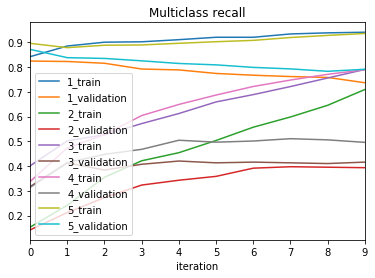

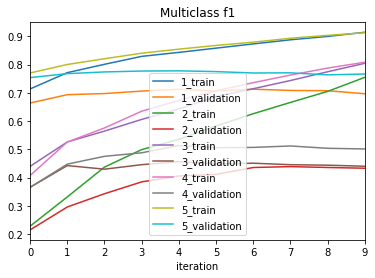

In [200]:
plot_class_label_metrics(metrics_mcnn)

The "more extreme categories do better than less extreme categories" pattern that I mentioned for bow is also present here.

Precision follows the same pattern that we saw for precision in general: precision gets better in training and doesn't change much in validation. Category 3 gets the most improvement in validation precision over training time. (Probably because 3's can be ambiguous - they list good things and bad things - so the model is helped by more examples to better learn the language patterns.)

Recall is a bit more varied. For training data, recall gets better over time (categories 1 and 5 have little room to improve, but they do get slightly better). For validation data, 1 and 5 get worse over time (I think that as the model gets better at recalling other categories, it gets worse at recalling 1s and 5s). 3s and 4s improve until iteration 4, then stay about the same. 2s (which we have fewer of and also probably have similar language to 1s) improve until iteration 6 and then stay about the same.

### Comparing CNN and Bag of Words (multiclass classifier)

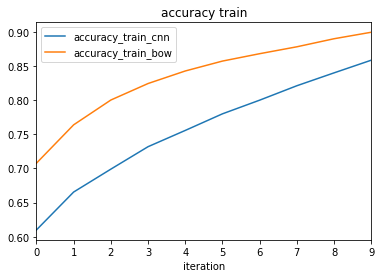

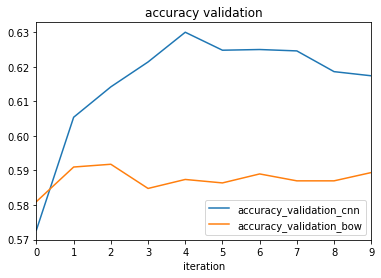

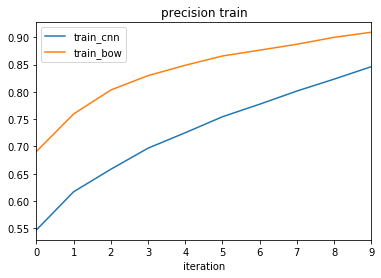

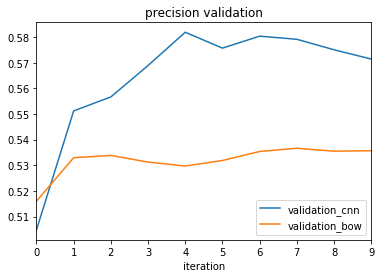

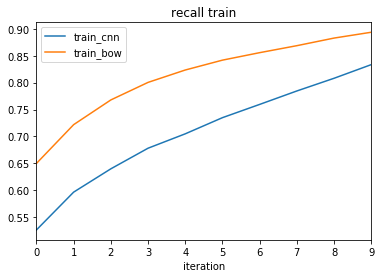

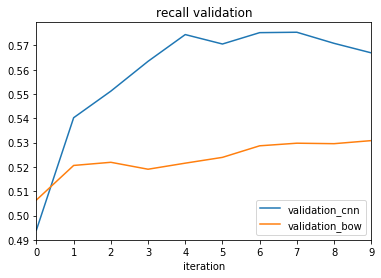

In [203]:
ax_t = metrics_mcnn.plot(x="iteration", y=f"accuracy_train", label="accuracy_train_cnn")
ax_v = metrics_mcnn.plot(x="iteration", y=f"accuracy_validation", label="accuracy_validation_cnn")
metrics_mbow.plot(x="iteration", y=f"accuracy_train", label="accuracy_train_bow", ax=ax_t)
metrics_mbow.plot(x="iteration", y=f"accuracy_validation", label="accuracy_validation_bow", ax=ax_v)
ax_t.set_title("accuracy train")
ax_v.set_title("accuracy validation")

for metric in ["precision", "recall"]:
    ax_t = None
    ax_v = None
    for metrics, name in zip([metrics_mcnn, metrics_mbow], ["cnn", "bow"]):
        ax_t = metrics.plot(x="iteration", y=f"{metric}_macro-avg_train", label=f"train_{name}", ax=ax_t)
        ax_v = metrics.plot(x="iteration", y=f"{metric}_macro-avg_validation", label=f"validation_{name}", ax=ax_v)
    ax_t.set_title(f"{metric} train")
    ax_v.set_title(f"{metric} validation")
    # hard to see difference between classifiers when you use the same axis
#     ax = None
#     for metrics, name in zip([metrics_mcnn, metrics_mbow], ["cnn", "bow"]):
#         ax = metrics.plot(x="iteration", y=f"{metric}_macro-avg_train", ax=ax)
#         metrics.plot(x="iteration", y=f"{metric}_macro-avg_validation", ax=ax)

When we do this zoomed in look, we can see that bow does better on the training set but CNN does better on the validation set.